# Identifying duplicate records in the City Planning Facilities database


A group project from NYC’s [Dept of City Planning Data Jam](https://beta.nyc/2017/04/25/announcing-dcp-datajam/), which took place at the American Planning Association's National Conference, held in New York City on Monday May 8, 2017.

#### Contributing Members: 

[Will Geary](http://willgeary.github.io/), [Manushi Majumdar](https://www.linkedin.com/in/manushimajumdar/), [Ian Stuart](https://www.linkedin.com/in/ianwstuart/), [Pooneh Famili](https://www.linkedin.com/in/pooneh-famili-ba007626/)





# Data challenge prompt

##### Background: 

The Department of City Planning aggregates information about 35,000+ facilities and program sites that are owned, operated, funded, licensed or certified by a City, State, or Federal agency in the City of New York into a central database called the [**City Planning Facilities Database (FacDB)**](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-selfac.page). These facilities generally help to shape quality of life in the city’s neighborhoods, and this dataset is the basis for a series of planning activities. This public data resource allows all New Yorkers to understand the breadth of government resources in their neighborhoods. This dataset is now complemented with the [**Facilities Explorer**](https://capitalplanning.nyc.gov/facilities), a new interactive web map that makes the data more accessible and allows users to quickly filter the data for their needs.

FacDB is produced by aggregating ~50 different data sources from different agencies. Multiple agencies can have an oversight relationship with the same facility or program site. For example, a single Pre-K program can be overseen by DOE, subsidized by ACS, and inspected by DOHMH. In these cases of overlapping oversight, the same facility will appear in multiple datasets, leading to duplicate records in FacDB. Scripts have been created to systematically identify these duplicate records and merge information from each record into one. However, due to discrepancies in spelling and descriptions of a site, some duplicate records are not being caught. This limits the analysis that can be done with FacDB, because concentration calculations are sometimes double counting facilities.

##### Goal:
Test and compare different methods that can improve the identification of duplicate records and merging of their attributes. Criteria for identifying duplicates should consider location, oversight agency, operator name, facility name, and facility category.

##### Supporting datasets and materials:
- Examples of duplicates in the data that are not being caught by scripts developed to remove duplicate records: [here](https://capitalplanning.nyc.gov/facilities/explorer#20/40.76832/-73.99177), [here](https://capitalplanning.nyc.gov/facilities/explorer#20/40.81256/-73.94825), and [here](https://capitalplanning.nyc.gov/facilities/explorer#20/40.80724/-73.88005).


- [FacDB Supplemental File Package](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-selfac.page): Contains a table of all original records aggregated into FacDB before any deduping and record merging was performed


- [FacDB GitHub Repo](https://github.com/NYCPlanning/facilities-db): Contains all the SQL scripts currently being used for deduping

# Here's an example of a known duplicate

The Polly Dodge Early Learning Center at 538 West 55 Street is a single facility with five records. It is operated by *The Young Women's Christian Association of the City of New York*. 

The facility names are inconsistent, and include: 

- "Polly Dodge Early Learning Center" (three records)
- "YWCA - NYC Polly Dodge ELC" (one record)
- "Young Women's Christian Association of the City of New York" (one record)

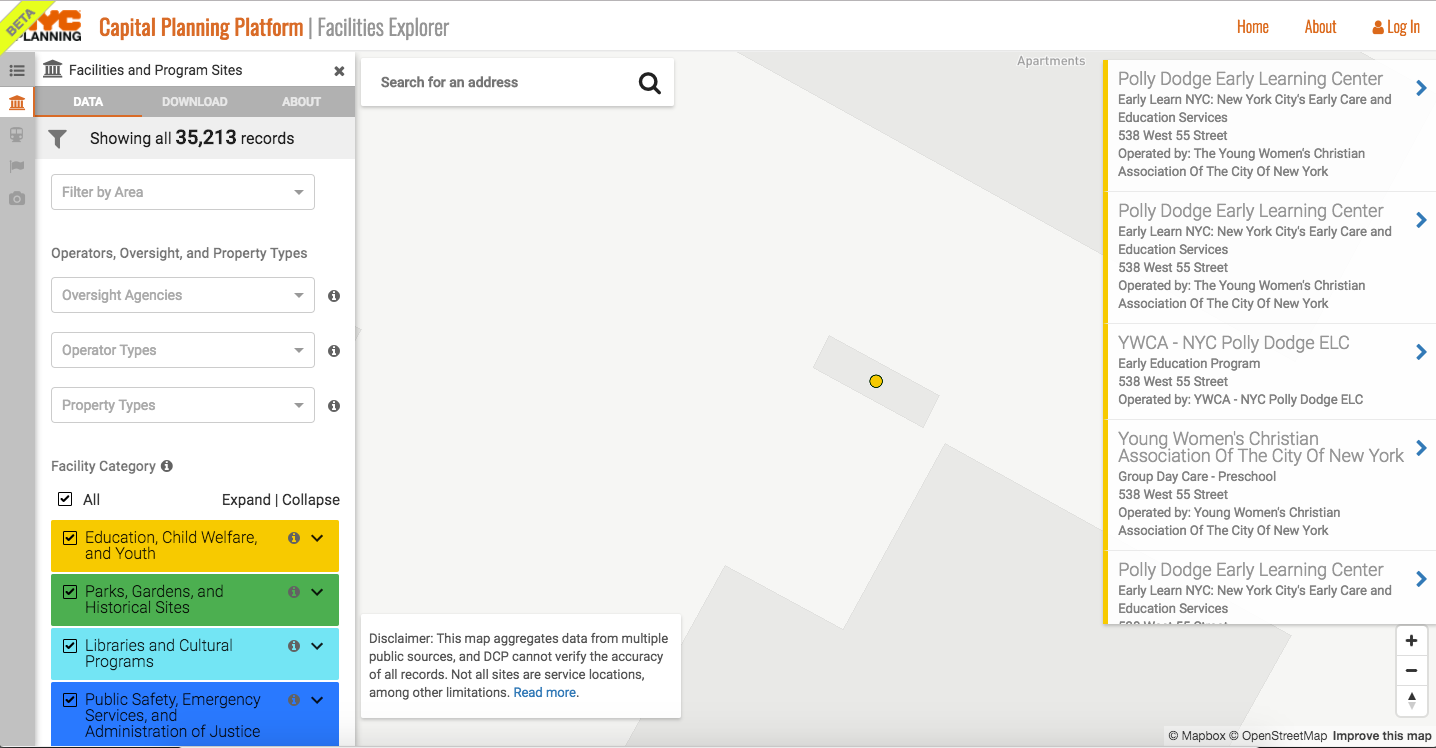

In [1]:
from IPython.display import Image
Image("http://i.imgur.com/0wuwo71.png")

# Let's use string matching to identify duplicate records 

We will make use of an python library [FuzzyWuzzy](https://github.com/seatgeek/fuzzywuzzy), which was created by New York-based SeatGeek and open sourced in 2011. Here's the original [blog post](http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/) about it. It uses [Levenshtein Distance](https://en.wikipedia.org/wiki/Levenshtein_distance) to calculate the differences between sequences of characters.

We will also use the following widely documented python libraries: pandas for numerical analysis, datetime for dealing with dates (only used here to time how long it takes functions to execute), and matplotlib for displaying images inline with our code.

# Import libraries

In [2]:
from fuzzywuzzy import fuzz # see: https://github.com/seatgeek/fuzzywuzzy
import pandas as pd
import datetime as dt
%matplotlib inline

Here's an example of using the fuzzywuzzy library to quantify the similarity between two strings:

In [3]:
string1 = "Hello there"
string2 = "Hallo their"
print "Similarity score between '{}' and '{}':".format(string1, string2), fuzz.partial_ratio(string1, string2)/100.0

Similarity score between 'Hello there' and 'Hallo their': 0.82


# Load the data

The below bash script downloads and unzips the latest available csv file from: https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-selfac.page.

The csv contains all 35,000+ records that are in the Facilities Database.

In [4]:
%%bash
wget https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/facilities-csv-2017.zip
unzip facilities-csv-2017.zip && rm -rf facilities-csv-2017.zip

Archive:  facilities-csv-2017.zip
  inflating: facilities.csv          


--2017-05-09 09:08:32--  https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/facilities-csv-2017.zip
Resolving www1.nyc.gov... 2600:141b:13:28f::1500, 2600:141b:13:292::1500, 23.217.171.105
Connecting to www1.nyc.gov|2600:141b:13:28f::1500|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6071755 (5.8M) [application/zip]
Saving to: ‘facilities-csv-2017.zip’

     0K .......... .......... .......... .......... ..........  0% 86.9K 68s
    50K .......... .......... .......... .......... ..........  1% 15.2M 34s
   100K .......... .......... .......... .......... ..........  2%  772K 25s
   150K .......... .......... .......... .......... ..........  3%  988K 20s
   200K .......... .......... .......... .......... ..........  4% 2.46M 16s
   250K .......... .......... .......... .......... ..........  5%  626K 15s
   300K .......... .......... .......... .......... ..........  5% 2.94M 13s
   350K .......... .......... .......... .......... ......

In [5]:
df = pd.read_csv("facilities.csv")

In [6]:
df.head(2)

,uid,hash,idold,idagency,facname,addressnum,streetname,address,city,boro,...,overagency,overabbrev,datasource,dataname,datalink,datadate,pgtable,uid_merged,hash_merged,geom
0,33492,a789c225b1ed04091a7eb14a93c8253c,NaN,NYCDCA: 1430208-DCA,Ud Parking Corp.,761,East 168 Street,761 East 168 Street,Bronx,Bronx,...,NYC Department of Consumer Affairs,NYCDCA,NYCDCA,NYCDCA: Legally Operating Businesses,NYCDCA: https://data.cityofnewyork.us/Business...,NYCDCA: 2017-01-20,dca_facilities_operatingbusinesses,NaN,NaN,0101000020E6100000FD37F6A1A97952C008247B61306A...
1,11451,77ec8a8ffdbe776aeeed1c37d6de9f34,NaN,NYCDOE: K274,P.S. 274 Kosciusko,800,Bushwick Avenue,800 Bushwick Avenue,Brooklyn,Brooklyn,...,NYC Department of Education,NYCDOE,NaN,:,:,:,doe_facilities_universalprek;dcas_facilities_colp,NaN,NaN,0101000020E6100000934B4BCC637B52C0A8AB7463E258...


In [7]:
print "The dataframe has {} records across {} columns.".format(df.shape[0], df.shape[1])

The dataframe has 35574 records across 47 columns.


In [8]:
print "Here are all of the column headers:"
print list(df.columns)

Here are all of the column headers:
['uid', 'hash', 'idold', 'idagency', 'facname', 'addressnum', 'streetname', 'address', 'city', 'boro', 'borocode', 'zipcode', 'latitude', 'longitude', 'xcoord', 'ycoord', 'bin', 'bbl', 'commboard', 'council', 'censtract', 'nta', 'facdomain', 'facgroup', 'facsubgrp', 'factype', 'capacity', 'util', 'captype', 'utilrate', 'area', 'areatype', 'proptype', 'optype', 'opname', 'opabbrev', 'overlevel', 'overagency', 'overabbrev', 'datasource', 'dataname', 'datalink', 'datadate', 'pgtable', 'uid_merged', 'hash_merged', 'geom']


# Concatenate `facname` + `address` + `city` into `fullName`

We will run the string matching algorithm against a newly definied field `fullName`, which is the concatenation of facility name, address and city.

In [9]:
df['fullName'] = df['facname'] + df['address'] + " " + df['city']

# Let's focus on the zip code where  Polly Dodge Early Learning Center is

Search for records by facility name:

In [10]:
facname_input = 'Polly Dodge Early Learning Center'

In [11]:
get_zipcodes = [int(i) for i in list(df[df['facname'] == facname_input]['zipcode'].values)]
print "{} is the `facname` for {} records with zip codes: {}".format(facname_input, len(get_zipcodes), get_zipcodes)

Polly Dodge Early Learning Center is the `facname` for 3 records with zip codes: [10019, 10019, 10019]


In [12]:
input_zipcode = get_zipcodes[0]

# Create similarity matrix for every record in this particular zip code

###### Input: 

(1) A zip code

(2) The facilities.csv table

(3) FuzzyMatch similarity score algorithm $f$

###### Output:

A matrix $M$ where value $M_{ij}$ is the similarity score on a scale from 1.0 and 0.0 between the `fullName` string of one record with `uid` == $i$ and the `fullName` string of another record with `uid` == $j$, according to FuzzyMatch's `partial_ratio` algorithm.

In [13]:
def similarity_matrix(input_zip, dataframe, f = fuzz.partial_ratio):

    # Only look at the input zip code
    zip_df = df[df['zipcode'] == input_zipcode]
    
    # Create an empty dataframe to store the results
    zip_df_similarity = pd.DataFrame(index=zip_df['uid'].values, columns=zip_df['uid'].values, dtype='float')
    
    print "start time =", dt.datetime.now()
    row_count = 0
    
    # Calculate the similarity score for every record pair
    # And insert it into the empty dataframe
    for i in zip_df_similarity.index:        
        rowname = str(df[df['uid'] == i]['fullName'].values[0])
        for c in zip_df_similarity.columns:
            colname = str(df[df['uid'] == c]['fullName'].values[0])
            similarityScore = f(rowname, colname)/100.0
            zip_df_similarity.ix[i][c] = similarityScore

        # Print out every tenth row count
        row_count += 1 
        if row_count % 10 == 0:
            print "finished row", row_count, "out of", len(zip_df_similarity), "at", dt.datetime.now()
    
    print "finish time =", dt.datetime.now()
    
    return zip_df_similarity

Run the function, and keep track of progress and time (it may take a few minutes).

In [14]:
output = similarity_matrix(input_zipcode, df)

start time = 2017-05-09 09:08:40.441792
finished row 10 out of 295 at 2017-05-09 09:08:45.804971
finished row 20 out of 295 at 2017-05-09 09:08:50.027389
finished row 30 out of 295 at 2017-05-09 09:08:54.340963
finished row 40 out of 295 at 2017-05-09 09:08:58.276472
finished row 50 out of 295 at 2017-05-09 09:09:02.556523
finished row 60 out of 295 at 2017-05-09 09:09:06.681436
finished row 70 out of 295 at 2017-05-09 09:09:10.018559
finished row 80 out of 295 at 2017-05-09 09:09:14.351547
finished row 90 out of 295 at 2017-05-09 09:09:18.757322
finished row 100 out of 295 at 2017-05-09 09:09:23.177950
finished row 110 out of 295 at 2017-05-09 09:09:28.048259
finished row 120 out of 295 at 2017-05-09 09:09:31.342566
finished row 130 out of 295 at 2017-05-09 09:09:34.848296
finished row 140 out of 295 at 2017-05-09 09:09:38.997822
finished row 150 out of 295 at 2017-05-09 09:09:43.046814
finished row 160 out of 295 at 2017-05-09 09:09:46.364924
finished row 170 out of 295 at 2017-05-09

# Similarity Matrix

Here's what the similarity matrix looks like. Notice that it is a symmetric matrix containing 1's along the diagonal (which is what would expect).

In [15]:
output

,35691,35896,22498,35400,8678,37684,37879,37692,35886,2045,...,35391,30041,35717,9817,34950,35744,34956,2047,34945,39115
35691,1.00,0.41,0.59,0.71,0.62,0.67,0.41,0.67,0.41,0.58,...,0.76,0.64,0.67,0.60,0.64,0.51,0.63,0.62,0.40,0.65
35896,0.41,1.00,0.41,0.44,0.46,0.39,0.53,0.44,0.41,0.43,...,0.43,0.42,0.44,0.44,0.45,0.39,0.42,0.41,0.57,0.43
22498,0.59,0.42,1.00,0.60,0.61,0.63,0.43,0.60,0.39,0.68,...,0.59,0.64,0.62,0.58,0.59,0.46,0.59,0.67,0.44,0.63
35400,0.71,0.44,0.60,1.00,0.65,0.63,0.40,0.65,0.41,0.65,...,0.73,0.67,0.62,0.60,0.69,0.55,0.60,0.63,0.44,0.63
8678,0.62,0.46,0.61,0.65,1.00,0.60,0.41,0.64,0.39,0.54,...,0.58,0.67,0.69,0.60,0.60,0.40,0.72,0.54,0.41,0.58
37684,0.67,0.39,0.63,0.63,0.60,1.00,0.45,0.60,0.43,0.57,...,0.69,0.66,0.64,0.60,0.72,0.48,0.58,0.64,0.43,0.57
37879,0.41,0.53,0.43,0.40,0.41,0.45,1.00,0.43,0.52,0.41,...,0.45,0.41,0.42,0.40,0.45,0.43,0.43,0.43,0.53,0.45
37692,0.67,0.44,0.60,0.65,0.64,0.60,0.43,1.00,0.50,0.63,...,0.62,0.76,0.64,0.61,0.64,0.44,0.73,0.58,0.42,0.64
35886,0.41,0.41,0.39,0.41,0.39,0.43,0.52,0.50,1.00,0.48,...,0.41,0.48,0.50,0.37,0.43,0.43,0.43,0.39,0.43,0.43
2045,0.58,0.43,0.68,0.65,0.54,0.57,0.41,0.63,0.48,1.00,...,0.57,0.67,0.62,0.58,0.57,0.44,0.54,0.72,0.44,0.62


# Similarity Heatmap

Create a heatmap to visualize the similarity matrix using Plotly using color to indicate the strength of the match. 

We will use the diverging color scale theme "Viridis" that is built in to Plotly, in which dark blue represents low similarity scores and bright yellow represents high similarity scores.

In [16]:
# You will need to have plotly installed to run this code

import plotly.plotly as py
import plotly.graph_objs as go

def reindex_matrix(similarity_matrix):
    '''Reindexes row and column names'''
    plotdata = similarity_matrix.copy()
    plotdata.reset_index(inplace=True, drop=True)
    plotdata.columns = range(len(plotdata.columns))
    return plotdata

def similarity_heatmap(similarity_matrix, title='Every Record in Zip Code {}'.format(input_zipcode)):
    '''Creates heatmap from the reindexed similarity matrix'''
    plotdata = reindex_matrix(similarity_matrix)
    
    data = [go.Heatmap(
        z = plotdata.values.tolist(),
        zmin = 0,
        zmax = 1,
        colorscale ='Viridis')]
    
    layout=go.Layout(
        title = title,
        xaxis = {'title':'Every Record'},
        yaxis = {'title':'Every Record'}
    )
    
    figure=go.Figure(data=data,layout=layout)
    return py.iplot(figure, filename='pandas-heatmap')

similarity_heatmap(output)

Link to full-screen version here: https://plot.ly/~willgeary/62.embed

# Visually identify duplicate records

For example, zoom in to row 153 and column 227... they appear to be a perfect match:

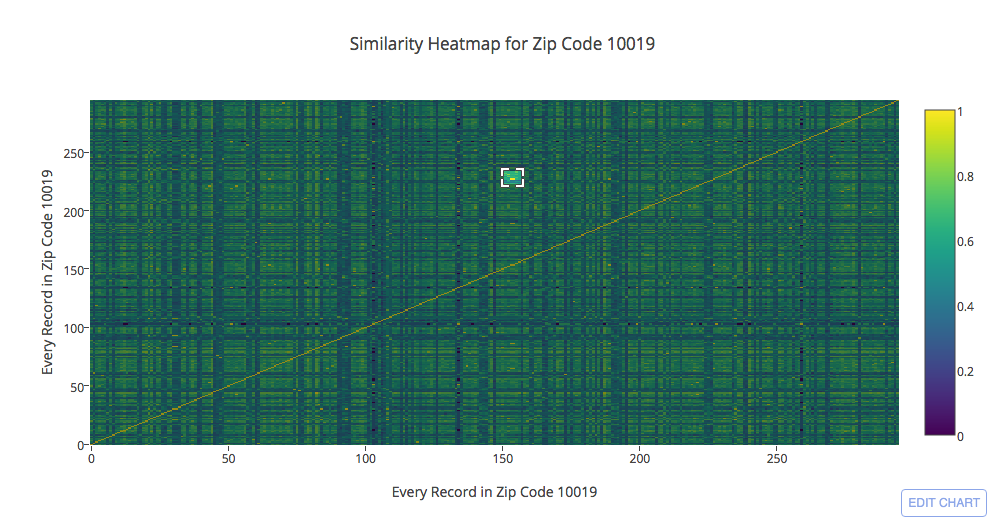

In [17]:
Image("http://i.imgur.com/SOERHgL.png")

Yep, these two records are a perfect match of 1.0:

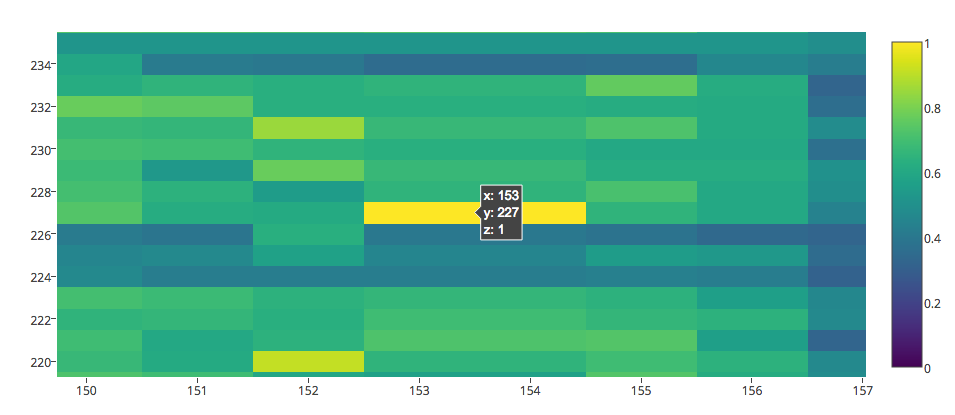

In [18]:
Image("http://i.imgur.com/83jioYQ.png")

Let's investigate these records...

In [19]:
record1_id = 153
record2_id = 227

In [20]:
print "#### Record 1 ####"
print "Full Name:", df[df['uid']==list(output.index)[record1_id]]['fullName'].values[0].replace(":","").replace("  ","")
print "Agency:", df[df['uid']==list(output.index)[record1_id]]['overagency'].values[0].replace(":","").replace("  ","")
print "Data Source:", df[df['uid']==list(output.index)[record1_id]]['dataname'].values[0].replace(":","").replace("  ","")
print "Data Link:", df[df['uid']==list(output.index)[record1_id]]['datalink'].values[0].replace("  ","")

print ""

print "#### Record 2 ####"
print "Full Name:", df[df['uid']==list(output.index)[record2_id]]['fullName'].values[0].replace(":","").replace("  ","")
print "Agency:", df[df['uid']==list(output.index)[record2_id]]['overagency'].values[0].replace(":","").replace("  ","")
print "Data Source:", df[df['uid']==list(output.index)[record2_id]]['dataname'].values[0].replace(":","").replace("  ","")
print "Data Link:", df[df['uid']==list(output.index)[record2_id]]['datalink'].values[0].replace("  ","")

#### Record 1 ####
Full Name: Midtown Community Court314 West 54 Street New York
Agency: NYC District Attorney - Manhattan
Data Source: NYCDCAS City Owned and Leased Properties
Data Link: NYCDCAS: http://www1.nyc.gov/site/planning/data-maps/open-data/dwn-colp.page

#### Record 2 ####
Full Name: Midtown Community Court314 West 54 Street New York
Agency: NYC Department of Youth and Community Development
Data Source:  
Data Link: : 


**We found duplicate records!** They are both instances of Midtown Community Court coming from two different sources.

# How do the known duplicates do?

Let's create a heatmap for the Polly Dodge Early Learning Center known duplicates and see what that looks like.

In [21]:
alternate_facnames = [
    "Polly Dodge Early Learning Center",
    "YWCA - NYC Polly Dodge ELC",
    "Young Women's Christian Association Of The City Of New York"
]

In [22]:
uids = []
for a in alternate_facnames:
    uid = df[df['facname'] == a]['uid'].values
    for i in uid:
        uids.append(i)

print "Unique ids for the {} records in question:".format(len(uids))
print uids

Unique ids for the 5 records in question:
[49518, 49517, 49515, 37687, 37691]


Here are the similarity scores between all of the known duplicates of the initial example "Polly Dodge Early Learning Center":

In [23]:
query_matrix = pd.DataFrame(index=uids, columns=uids, dtype=float)

for i in uids:
    for j in uids:
        similarity_score = output[output.index == i][j].values[0]
        query_matrix[i][j] = similarity_score
        
query_matrix

,49518,49517,49515,37687,37691
49518,1.00,1.00,1.00,0.67,0.63
49517,1.00,1.00,1.00,0.67,0.63
49515,1.00,1.00,1.00,0.67,0.63
37687,0.67,0.67,0.67,1.00,0.65
37691,0.63,0.63,0.63,0.65,1.00


In [24]:
similarity_heatmap(query_matrix, title="Similarity Heatmap for Polly Dodge Learning Center Known Duplicates")

The similarity scores between the known Polly Dodge Learning Center duplicate records range from 0.63 to 1.0.

# Future steps

Ideas for future improvements to identifiying duplicate records include:

- Tweak the similarity score algorithm to put more weight on the address and less weight on the facility name
- Create an `Acronym` field and calculate similarity scores for acronyms and well as facility name and address
- Drop meaningless substrings like 'Inc' from the facility names to improve string matching